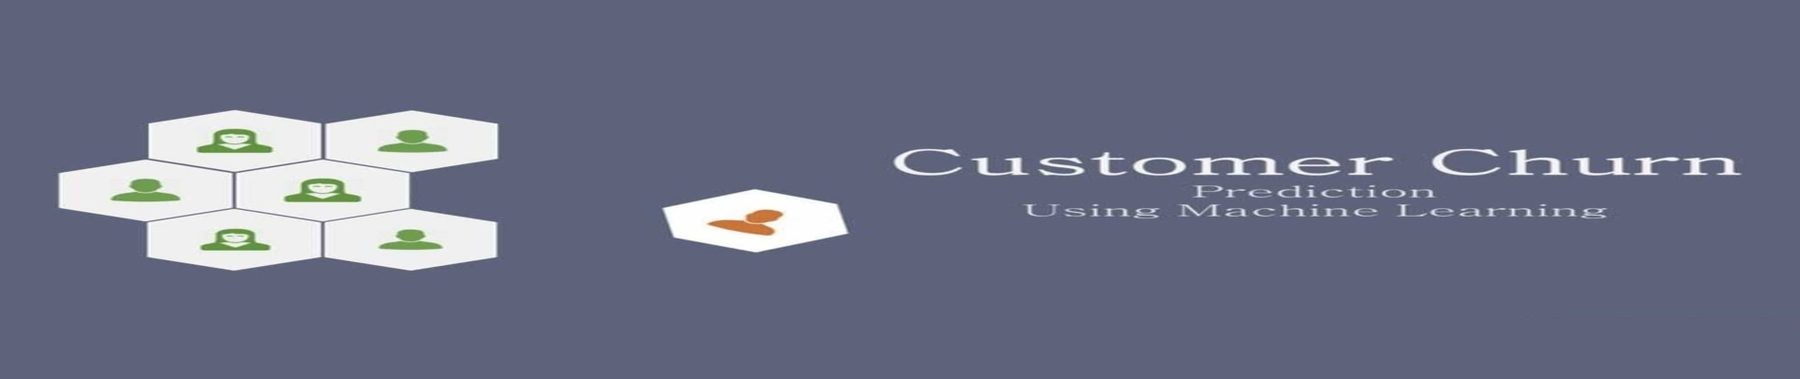

# <center> Отток клиентов банка

## <center> Прогнозирование оттока клиентов банка с помощью моделей логистической регрессии и случайного леса

---

## Постановка задачи

Нам предстоит решить задачу прогнозирования оттока клиентов банка. 

Контекст задачи:

> Представим, что некоторый банк обратился к нам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого нужно спрогнозировать вероятности оттока клиентов и определить, уйдёт ли конкретный клиент в ближайшее время. 

**Наша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


---

## Знакомство с данными

Для начала импортируем библиотеки, которые нам понадобятся:

In [21]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
from sklearn import tree #модели на основе дерева решений
from sklearn import ensemble #модуль ансамблевых методов

%matplotlib inline
plt.style.use('seaborn-v0_8')

Итак, прочитаем нашу таблицу:

In [22]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<center> <b>Разбор признаков</b>

|ПРИЗНАК|ОПИСАНИЕ|
|-|-|
|RowNumber|номер строки таблицы (это лишняя информация, поэтому мы от неё избавимся)|
|CustomerId|идентификатор клиента|
|Surname|фамилия клиента|
|CreditScore|кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их)|
|Geography|страна клиента (банк международный)|
|Gender|пол клиента|
|Age|возраст клиента|
|Tenure|сколько лет клиент пользуется услугами банка|
|Balance|баланс на счетах клиента в банке|
|NumOfProducts|количество услуг банка, которые приобрёл клиент|
|HasCrCard|есть ли у клиента кредитная карта (1 — да, 0 — нет)|
|IsActiveMember|есть ли у клиента статус активного клиента банка (1 — да, 0 — нет)|
|EstimatedSalary|предполагаемая заработная плата клиента|
|Exited|статус лояльности (1 — ушедший клиент, 0 — лояльный клиент)|

### Визуализация

Для полноты исследования проведем небольшой разведывательный анализ данных. Построим графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные.

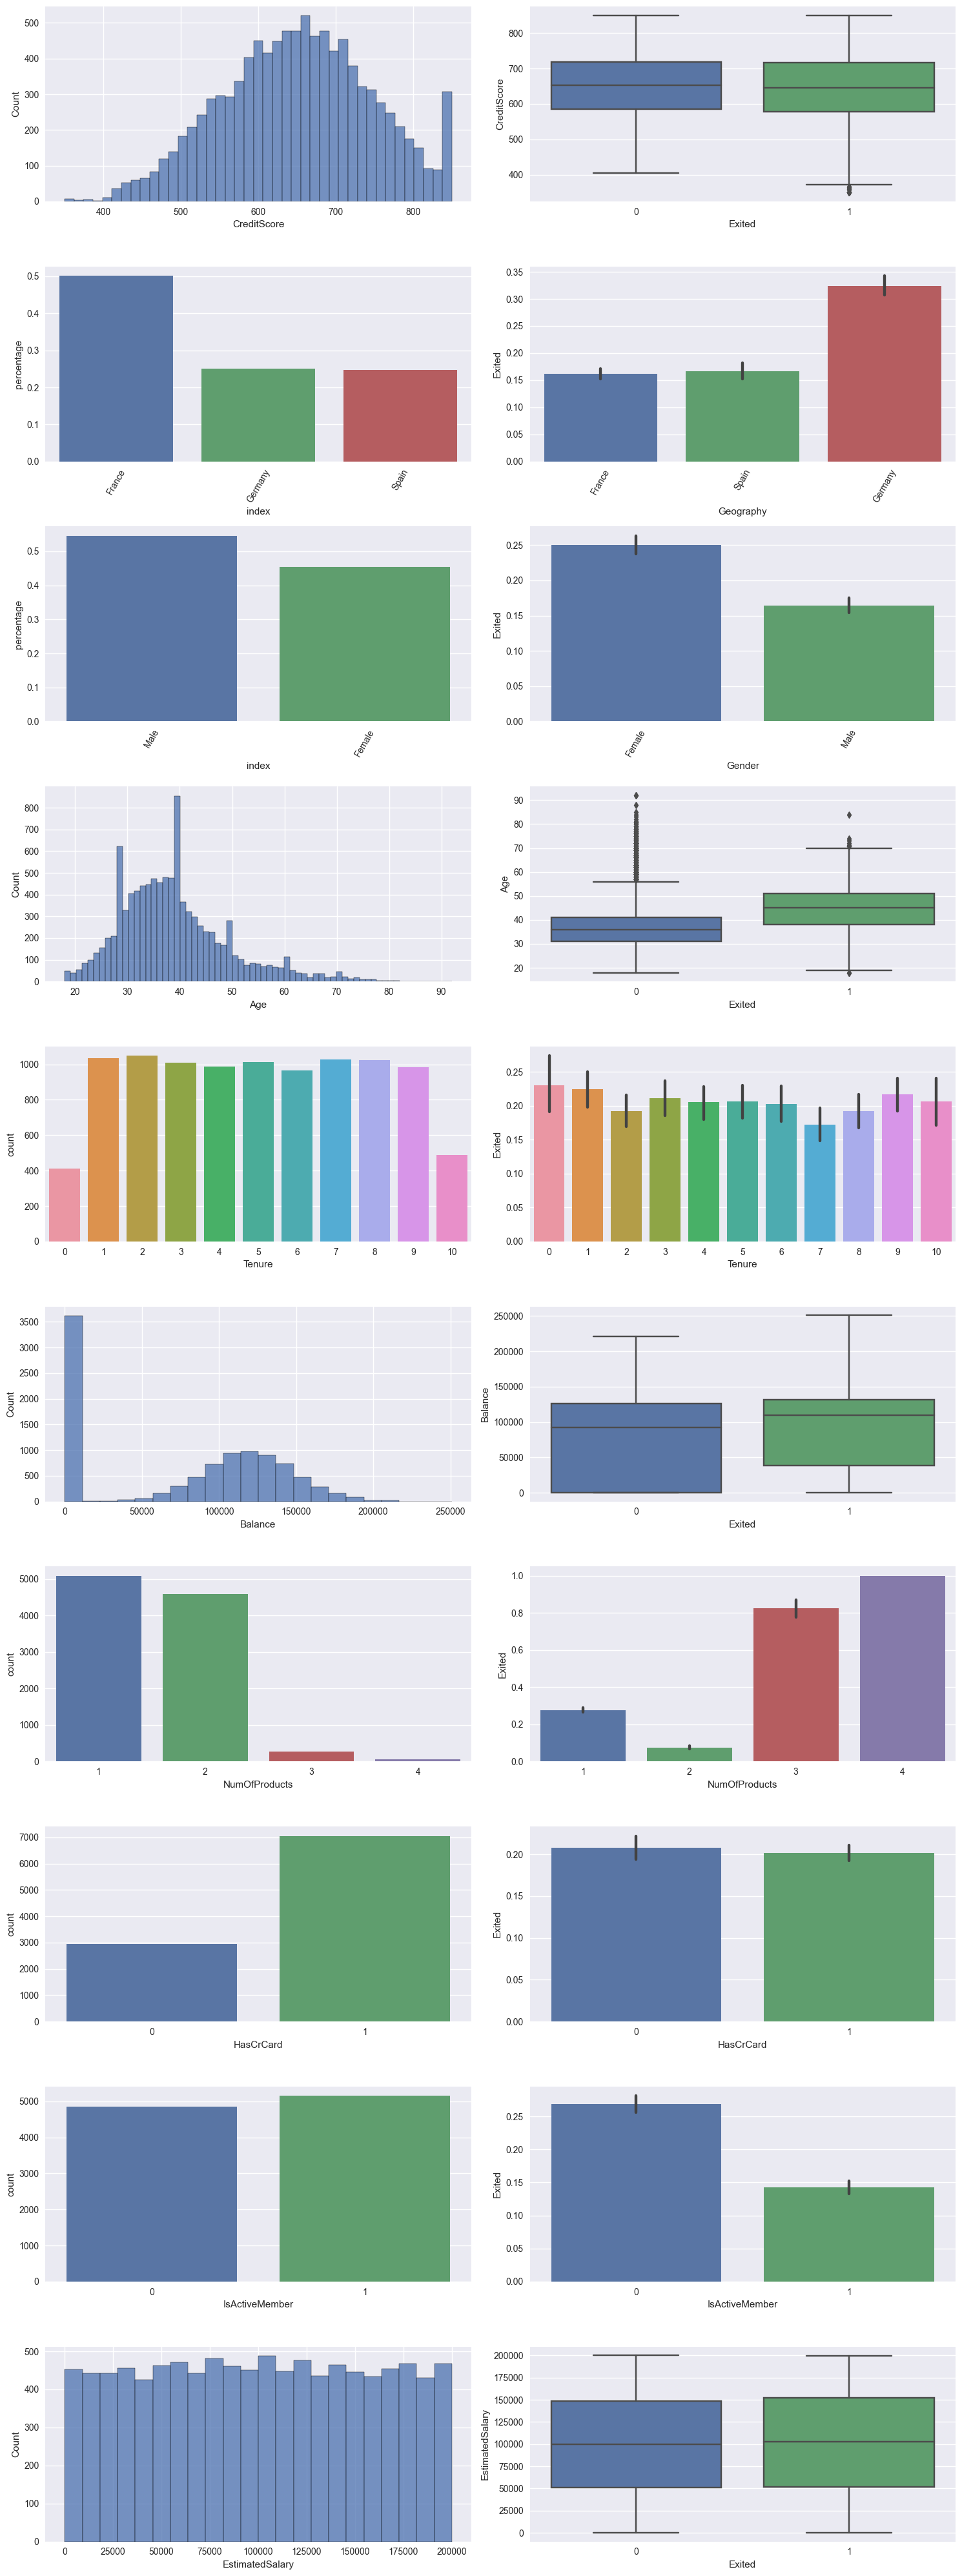

In [23]:
# Составим список признаков, исключив номер строки, ID и имя клиента.
features = list(churn_data.columns[3:-1])
n = len(features) # Число категориальных признаков.
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # Фигура+n*2 координатных плоскостей.
# Создаём цикл для всех признаков из списка категориальных признаков.
for i, feature in enumerate(features):
    if churn_data[feature].dtypes == 'object':
        # Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных.
        count_data = (churn_data[feature].value_counts(normalize=True)
                      .sort_values(ascending=False)
                      .rename('percentage')
                      .reset_index())
        count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
        count_barplot.xaxis.set_tick_params(rotation=60)
        # Строим столбчатую диаграмму в зависимости от категории лояльности.
        mean_barplot = sns.barplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
        mean_barplot.xaxis.set_tick_params(rotation=60)
    elif churn_data[feature].dtypes != 'object' and churn_data[feature].nunique() > 11:
        # Строим гистограмму распределения значений и коробчатую диаграмму для некатегориальных признаков
        # с числом уникальных значений более 11: мы вынуждены идти на такое ухищрение потому, что
        # порядковые категориальные значения в датасете представлены в одном типе с числовыми.
        sns.histplot(data=churn_data, x=feature, ax=axes[i][0])
        sns.boxplot(data=churn_data, y=feature, x='Exited', ax=axes[i][1])
    else:
        # Строим счетчик наблюдений и столбчатую диаграмму для порядковых категориальных призщнаков.
        sns.countplot(data=churn_data, x=feature, ax=axes[i][0])
        sns.barplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
plt.tight_layout() #выравнивание графиков

Мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка, т.к. клиентский отток там наиболее плачевный.<br>Следовательно, нам нужно выделить только данные, что относятся к Германии:

In [24]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
# Размер получившейся выборки.
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [25]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [26]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [27]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

На этом, пожалуй, наш скорый обзор данных и их анализ можно приостановить, чтобы приступить уже к машинному обучению.

---

# <center> Часть 1. Логистическая регрессия

---

## Предобработка данных

### Feature Engineering

Для начала расширим датасет с помощью методов **Feature Engineering**. Создадим следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.<br>
И выведим основные статистические характеристики полученных признаков.

In [28]:
# Создадим новые признаки.
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']
# Перекодируем оставшийся категориальный признак.
churn_data = pd.get_dummies(churn_data, drop_first=True)
# Выведем описательную статистику.
churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [29]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [30]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [32]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Масштабирование

Позаботимся о масштабировании признаков. Проведем нормализацию матрицы наблюдений `X` с помощью `MinMaxScaler`.

In [33]:
# Производим нормализацию данных с помощью min-max нормализации
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Выбор метрики

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра, и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Мы не можем положиться на <b><i>accuracy</i></b>, т.к. имеем дело с несбалансированными классами.<br>
<b><i>precision</i></b> полезен, когда нам важно уменьшить число случаев ложноположительных результатов, но теряется контроль над чувствительностью модели к истинно положительным объектам.<br>
<b><i>recall</i></b> нужен для оценки числа ложноотрицательных результатов, при этом упускается из виду разборчивость модели в отношении истинно отрицательных объектов.<br>
Следовательно, мы будем пытаться улучшить метрику $F_1$, т.к. она даёт обобщённое представление о точности и полноте, т.е. балансирует между <b><i>precision</i></b> и <b><i>recall</i></b>.

### Моделирование

Обучим модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботимся о воспроизводимости результата, установив конкретное значение параметра `random_state` (число 42).<br>
Сделаем предсказание меток классов для тренировочной и тестовой выборок.<br>
Рассчитаем значение целевой метрики на тренировочной и тестовой выборках.

Попробуем также поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдаем, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

In [34]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    C=19.19
)
# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
# Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.62      0.43      0.51       610

    accuracy                           0.73      1881
   macro avg       0.69      0.65      0.66      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       424
           1       0.60      0.42      0.50       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.71       628



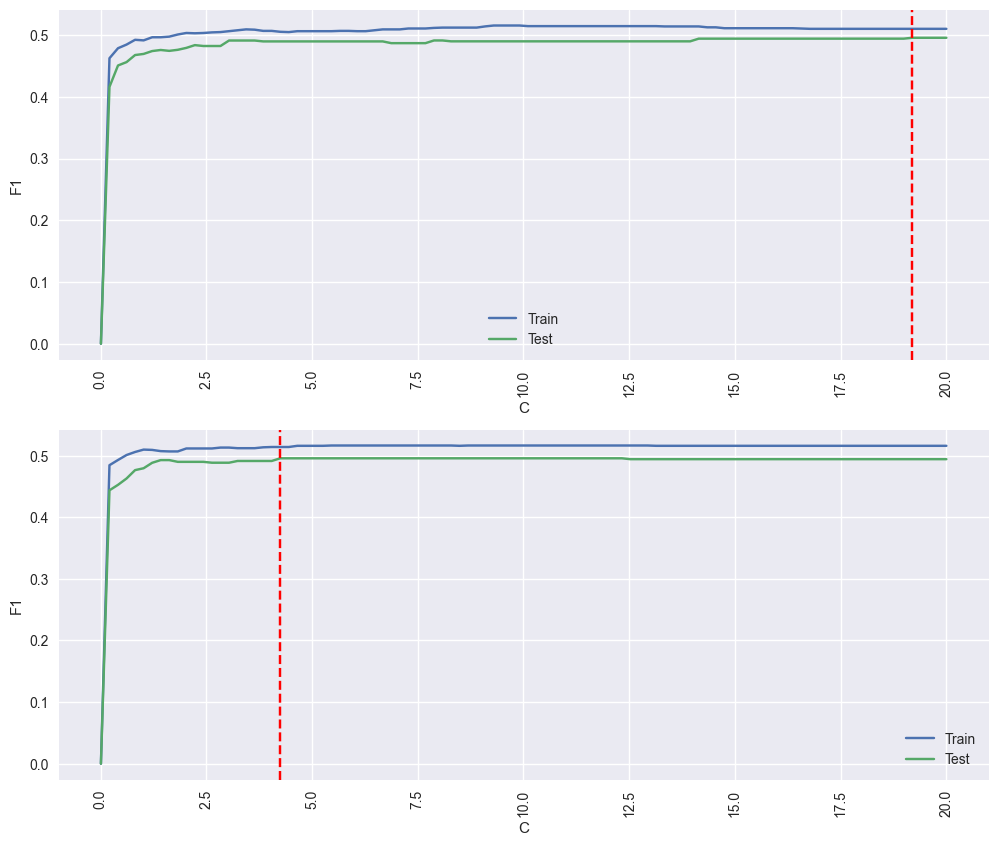

In [15]:
# Создаем список из 100 возможных значений от 0.01 до 20
c_list = np.linspace(0.01, 20, 100)
# Создаем пустые списки, в которые будем добавлять результаты 
train_scores_l2, test_scores_l2 = [], []
train_scores_l1, test_scores_l1 = [], []
# Создаем переменные для определения максимума
c_for_max_l2, c_for_max_l1 = c_list[0], c_list[0]
max_f1_l2, max_f1_l1 = 0, 0
for c in c_list:
    # Создаем объект класса лог-регрессия с L2-регуляризацией
    log_reg_l2 = linear_model.LogisticRegression(
        solver='sag', # алгоритм оптимизации
        random_state=42, # генератор случайных чисел
        C=c, # обратный коэффициент регуляризации
        max_iter=1000
    )
    # Обучаем модель
    log_reg_l2.fit(X_train_scaled, y_train)
    # Делаем предсказание для каждой из выборок
    y_train_predict_l2 = log_reg_l2.predict(X_train_scaled)
    y_test_predict_l2 = log_reg_l2.predict(X_test_scaled)
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores_l2.append(metrics.f1_score(y_train, y_train_predict_l2))
    f1_l2 = metrics.f1_score(y_test, y_test_predict_l2)
    test_scores_l2.append(f1_l2)
    # Переопределяем максимумы
    if f1_l2 > max_f1_l2:
        max_f1_l2 = f1_l2
        c_for_max_l2 = c
    
    # Создаем объект класса лог-регрессия с L1-регуляризацией
    log_reg_l1 = linear_model.LogisticRegression(
        solver='saga', # алгоритм оптимизации
        random_state=42, # генератор случайных чисел
        penalty='l1', # метод регуляризации
        C=c, # обратный коэффициент регуляризации
        max_iter=1000
    )
    # Обучаем модель
    log_reg_l1.fit(X_train_scaled, y_train)
    # Делаем предсказание для каждой из выборок
    y_train_predict_l1 = log_reg_l1.predict(X_train_scaled)
    y_test_predict_l1 = log_reg_l1.predict(X_test_scaled)
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores_l1.append(metrics.f1_score(y_train, y_train_predict_l1))
    f1_l1 = metrics.f1_score(y_test, y_test_predict_l1)
    test_scores_l1.append(f1_l1)
    # Переопределяем максимумы
    if f1_l1 > max_f1_l1:
        max_f1_l1 = f1_l1
        c_for_max_l1 = c

# Визуализируем изменение F1 в зависимости от C
fig, ax = plt.subplots(2, 1, figsize=(12, 10)) # фигура + координатная плоскость
ax[0].plot(c_list, train_scores_l2, label='Train') # линейный график для тренировочной выборки
ax[0].plot(c_list, test_scores_l2, label='Test') # линейный график для тестовой выборки
ax[0].set_xlabel('С') # название оси абсцисс
ax[0].set_ylabel('F1') # название оси ординат
ax[0].xaxis.set_tick_params(rotation=90) # поворот меток на оси абсцисс
ax[0].axvline(x=c_for_max_l2, color='red', linestyle='--') # добавляем вертикальную линию
ax[0].legend() # отображение легенды

ax[1].plot(c_list, train_scores_l1, label='Train') # линейный график для тренировочной выборки
ax[1].plot(c_list, test_scores_l1, label='Test') # линейный график для тестовой выборки
ax[1].set_xlabel('С') # название оси абсцисс
ax[1].set_ylabel('F1') # название оси ординат
ax[1].xaxis.set_tick_params(rotation=90) # поворот меток на оси абсцисс
ax[1].axvline(x=c_for_max_l1, color='red', linestyle='--', ) # добавляем вертикальную линию
ax[1].legend(); # отображение легенды

In [16]:
print(f'Макс. значение F-меры {round(max_f1_l1, 4)} для l1-рег. достигается при значении коэф. С {round(c_for_max_l1, 4)}')
print(f'Макс. значение F-меры {round(max_f1_l2, 4)} для l2-рег. достигается при значении коэф. С {round(c_for_max_l2, 4)}')

Макс. значение F-меры 0.4957 для l1-рег. достигается при значении коэф. С 4.2503
Макс. значение F-меры 0.4957 для l2-рег. достигается при значении коэф. С 19.1923


**Вывод**

К сожалению, наша модель недообучена: как это видно по результатам тестирования модели на разных коэффициентах $c$ со сменой типа регуляризации, $F_1$ не дотягивает до границы 0.5.

### + полиномиальные признаки

Сгенерируем полиномиальные признаки третьей степени для тренировочной и тестовой выборок и повторим прежний поряок действий.

In [25]:
# Создаем объект для генерации полиномиальных признаков 3 степени.
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
# Вычисляем параметры генерации - результирующее количество признак.
poly.fit(X_train_scaled)
# Производим преобразование для каждой из выборок.
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))
print()

# Создаем объект класса логистическая регрессия
log_reg_poly = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=5000, #максимальное число итераций
    penalty='l1', #тип регуляризации
    C=12.3115 #коэффициент смягчения регуляризации
)
# Обучаем модель, минимизируя logloss
log_reg_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred_poly = log_reg_poly.predict(X_train_scaled_poly)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_poly))
# Делаем предсказание для тестовой выборки
y_test_pred_poly = log_reg_poly.predict(X_test_scaled_poly)
# Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_poly))

Train shape: (1881, 454)
Test shape: (628, 454)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1271
           1       0.78      0.68      0.73       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       424
           1       0.72      0.65      0.69       204

    accuracy                           0.81       628
   macro avg       0.78      0.77      0.77       628
weighted avg       0.80      0.81      0.80       628



Wall time: 12min 25s


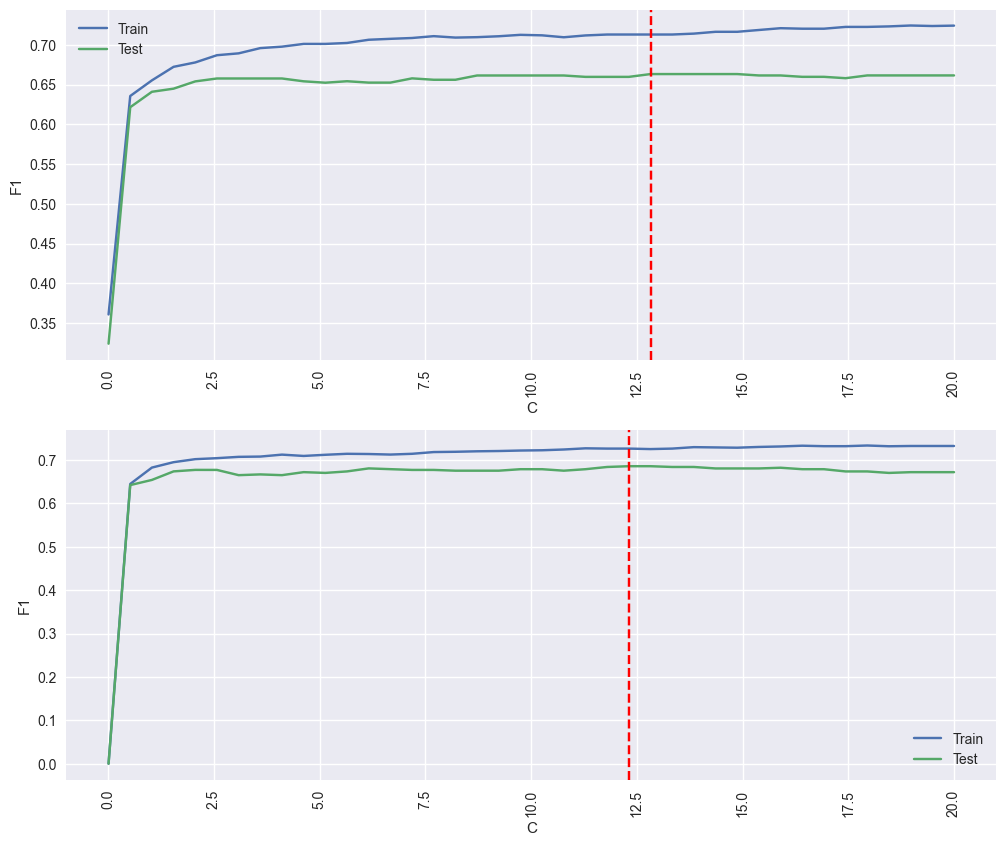

In [18]:
%%time

#Создаем список из 100 возможных значений от 0.01 до 20
c_poly_list = np.linspace(0.01, 20, 40)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores_poly_l2, test_scores_poly_l2 = [], []
train_scores_poly_l1, test_scores_poly_l1 = [], []
c_for_max_poly_l2, c_for_max_poly_l1 = c_list[0], c_list[0]
max_f1_poly_l2, max_f1_poly_l1 = 0, 0
for c in c_poly_list:
    #Создаем объект класса лог-регрессия с L2-регуляризацией
    log_reg_poly_l2 = linear_model.LogisticRegression(
        solver='saga', #алгоритм оптимизации
        random_state=42, #генератор случайных чисел
        C=c, #обратный коэффициент регуляризации
        max_iter=10000,
        n_jobs=-1
    )
    #Обучаем модель
    log_reg_poly_l2.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_predict_poly_l2 = log_reg_poly_l2.predict(X_train_scaled_poly)
    y_test_predict_poly_l2 = log_reg_poly_l2.predict(X_test_scaled_poly)
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores_poly_l2.append(metrics.f1_score(y_train, y_train_predict_poly_l2))
    f1_poly_l2 = metrics.f1_score(y_test, y_test_predict_poly_l2)
    test_scores_poly_l2.append(f1_poly_l2)
    if f1_poly_l2 > max_f1_poly_l2:
        max_f1_poly_l2 = f1_poly_l2
        c_for_max_poly_l2 = c
    
    #Создаем объект класса лог-регрессия с L1-регуляризацией
    log_reg_poly_l1 = linear_model.LogisticRegression(
        solver='saga', #алгоритм оптимизации
        random_state=42, #генератор случайных чисел
        penalty='l1', #метод регуляризации
        C=c, #обратный коэффициент регуляризации
        max_iter=10000,
        n_jobs=-1
    )
    #Обучаем модель
    log_reg_poly_l1.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_predict_poly_l1 = log_reg_poly_l1.predict(X_train_scaled_poly)
    y_test_predict_poly_l1 = log_reg_poly_l1.predict(X_test_scaled_poly)
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores_poly_l1.append(metrics.f1_score(y_train, y_train_predict_poly_l1))
    f1_poly_l1 = metrics.f1_score(y_test, y_test_predict_poly_l1)
    test_scores_poly_l1.append(f1_poly_l1)
    if f1_poly_l1 > max_f1_poly_l1:
        max_f1_poly_l1 = f1_poly_l1
        c_for_max_poly_l1 = c

#Визуализируем изменение F1 в зависимости от C
fig, ax = plt.subplots(2, 1, figsize=(12, 10)) #фигура + координатная плоскость
ax[0].plot(c_poly_list, train_scores_poly_l2, label='Train') #линейный график для тренировочной выборки
ax[0].plot(c_poly_list, test_scores_poly_l2, label='Test') #линейный график для тестовой выборки
ax[0].set_xlabel('С') #название оси абсцисс
ax[0].set_ylabel('F1') #название оси ординат
ax[0].xaxis.set_tick_params(rotation=90) #поворот меток на оси абсцисс
ax[0].axvline(x=c_for_max_poly_l2, color='red', linestyle='--') 
ax[0].legend(); #отображение легенды

ax[1].plot(c_poly_list, train_scores_poly_l1, label='Train') #линейный график для тренировочной выборки
ax[1].plot(c_poly_list, test_scores_poly_l1, label='Test') #линейный график для тестовой выборки
ax[1].set_xlabel('С') #название оси абсцисс
ax[1].set_ylabel('F1') #название оси ординат
ax[1].xaxis.set_tick_params(rotation=90) #поворот меток на оси абсцисс
ax[1].axvline(x=c_for_max_poly_l1, color='red', linestyle='--', )
ax[1].legend(); #отображение легенды

In [19]:
print(f'Макс. значение F-меры {round(max_f1_poly_l1, 4)} для l1-рег. достигается при значении коэф. С {round(c_for_max_poly_l1, 4)}')
print(f'Макс. значение F-меры {round(max_f1_poly_l2, 4)} для l2-рег. достигается при значении коэф. С {round(c_for_max_poly_l2, 4)}')

Макс. значение F-меры 0.6856 для l1-рег. достигается при значении коэф. С 12.3115
Макс. значение F-меры 0.6632 для l2-рег. достигается при значении коэф. С 12.8241


**Вывод**

Качество модели заметно улучшилось: значение $F_1$ теперь почти 0,69 для тестовой выборки.

### Подбор порога вероятности

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используем логистическую регрессию, обученную на полиномиальных признаках. 

Построим также график зависимости целевой метрики от порога вероятности. На основе построенного графика определим порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделаем предсказание классов с подобранным оптимальным порогом вероятности. Рассчитаем значение целевой метрики на тестовой выборке и сравним результат с полученными ранее.

Макс. значение F-меры 0.7074 достигается при значении порога 0.3


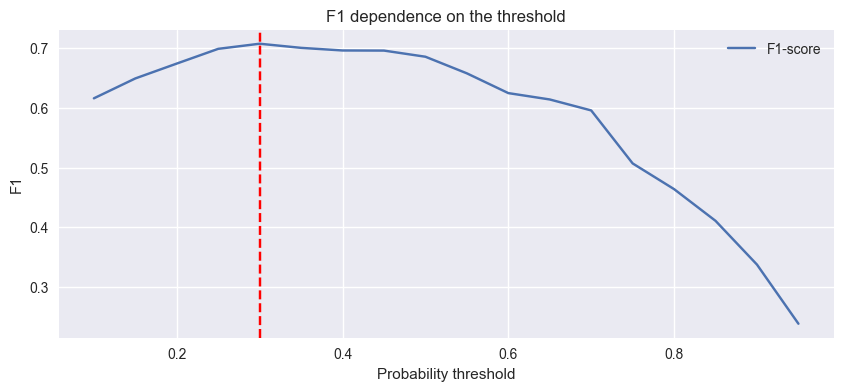

In [20]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_scaled_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
max_f1, max_threshold = 0, thresholds[0]
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику и добавляем результат в список
    f1 = metrics.f1_score(y_test, y_test_pred_poly)
    f1_scores.append(f1)
    if f1 > max_f1:
        max_f1 = f1
        max_threshold = threshold

# Визуализируем метрику при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) # фигура + координатная плоскость
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
# Даем графику название и подписи осям
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('F1')
ax.axvline(x=max_threshold, color='red', linestyle='--', )
ax.legend();

print(f'Макс. значение F-меры {round(max_f1, 4)} достигается при значении порога {round(max_threshold, 2)}')

In [21]:
# Задаем оптимальный порог вероятностей
threshold_opt = 0.3
# Делаем предсказание вероятности оттока для каждого клиента также из треннировочной выборки
y_train_proba_pred = pd.Series(log_reg_poly.predict_proba(X_train_scaled_poly)[:, 1])
# Клиенты, вероятность ухода которых больше 0.3 относим к классу 1
# В противном случае - к классу 0
y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(metrics.classification_report(y_train, y_train_pred_opt))
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1271
           1       0.64      0.84      0.73       610

    accuracy                           0.80      1881
   macro avg       0.78      0.81      0.78      1881
weighted avg       0.82      0.80      0.80      1881

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       424
           1       0.62      0.82      0.71       204

    accuracy                           0.78       628
   macro avg       0.76      0.79      0.76       628
weighted avg       0.81      0.78      0.78       628



**Вывод**

Таким образом, нам удалось улучшить значение $F_1$ для тестовой выборки почти до 0,71.

---

# <center> Часть 2. Деревья решений и случайный лес

---

## Деревья решений

Мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

Теперь попробуем решить задачу с помощью деревьев решений и лесов.

> **Примечание.**<br> Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи мы будем использовать исходные обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.

Обучим на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности будем использовать энтропию Шеннона, остальные параметры оставим пока по умолчанию.

In [16]:
#Создаем объект класса дерево решений
dtc_max_heigh = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    #min_samples_leaf=_,
    #max_depth=_,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dtc_max_heigh.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dtc_max_heigh.predict(X_train)
print('Train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dtc_max_heigh.predict(X_test)
print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.000
Test: 0.527


**Вывод**

Полученная модель явно является переобученной: мы видим максимальное значение метрики на данных треннировочной выборки, и значение почти равное половине от него - на данных тестовой выборки. Так произошло потому, что мы не ограничили максимальную глубину ветвления модели, и она буквально описала весь предоставленный ей датасет.</span>

### Подстрижем дерево

Обучим теперь наше дерево решений с максимальной глубиной 8. Критерий информативности оставим прежний, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

In [17]:
#Создаем объект класса дерево решений
dt_opt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    min_samples_leaf=10, #минимальное число объектов в листе
    max_depth=8, #максимальная глубина деревьев
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt_opt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt_opt.predict(X_train)
print('Train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt_opt.predict(X_test)
print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.717
Test: 0.651


**Вывод**

Значение метрики на тестовой выборке стало лучше: модель не подстроилась под данные треннировочной выборки и получила обобщающее свойство.

---

## Случайный лес

Построим случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе — 10.

In [18]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500, #размер леса
    max_depth=8, #глубина деревьев
    criterion='entropy', #критерий информативности
    min_samples_leaf=10, #минимальное число объектов в листе
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.729
Test: 0.645


**Вывод**

Увы, случайный лес при данных параметрах смог добиться лишь почти такой же точности, что и одинокое дерево решений, и, вдобавок, модель чуть лучше подстролась под треннировочные данные.

### Лес оптимизированный

Попробуем теперь подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке.

Построим график зависимости целевой метрики от порога вероятности. На основе построенного графика определим порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделаем предсказание классов с подобранным оптимальным порогом вероятности. Рассчитаем значение целевой метрики на тестовой выборке и сравним полученный результат с полученными ранее.

> **Примечание.** В реальных задачах мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока наша метрика превышает хотя бы значения 0.6-0.7, то модель уже можно считать хорошей.

Train: 0.745
Test: 0.659
Макс. значение F-меры 0.6962 достигается при значении порога 0.35


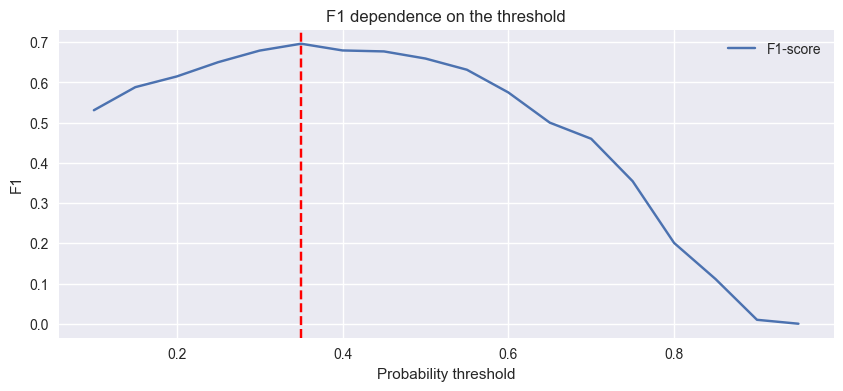

In [19]:
#Создаем объект класса случайный лес
rf_opt = ensemble.RandomForestClassifier(
    n_estimators=500, #размер леса
    max_depth=8, #глубина деревьев
    criterion='entropy', #критерий информативности
    min_samples_leaf=6, #минимальное число объектов в листе
    random_state=42
)
#Обучаем модель
rf_opt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf_opt.predict(X_train)
print('Train: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf_opt.predict(X_test)
print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf_opt.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
max_f1, max_threshold = 0, thresholds[0]
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику и добавляем результат в список
    f1 = metrics.f1_score(y_test, y_test_pred)
    f1_scores.append(f1)
    if f1 > max_f1:
        max_f1 = f1
        max_threshold = threshold

#Визуализируем метрику при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('F1')
ax.axvline(x=max_threshold, color='red', linestyle='--', )
ax.legend();

print(f'Макс. значение F-меры {round(max_f1, 4)} достигается при значении порога {round(max_threshold, 2)}')

**Вывод**

Нам удалось улучшить значение $F_1$ для тестовой выборки, оно теперь равно 0.6962. Полученный результат, увы, не точнее чем тот, что нам дала логистическая регрессия на полиномиальных признаках: лучшее значение F-меры с той моделью равно 0.7074. Однако, итоговые модели, можно сказать, дают приблизительно одинаковый хороший результат и справляются со своей задачей.

---

# <center> Тест моделей на новых данных

---

Допустим, у нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью получившихся у нас моделей спрогнозируем вероятность того, что Василий откажется от услуг банка.

> На самом деле мы знаем верный ответ: клиентский класс Василися должен быть 1. Т.е. мы сможем оценить работу наших моделей.

Но сперва, разумеется, мы преобразовать данные к тому формату, на котором обучались модели.

In [26]:
#Создаем датафрейм из новых данных
new = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})
# Создадим новые признаки.
new['BalanceSalaryRatio'] = new['Balance'] / new['EstimatedSalary']
new['TenureByAge'] = new['Tenure'] / new['Age']
new['CreditScoreGivenAge'] = new['CreditScore'] / new['Age']
# Перекодируем категориальный признак
new['Gender_Male'] = 1
new = new.drop(['Gender'], axis=1)
#Нормализуем данные
new_scaled = scaler.transform(new)
#Добавим полиномиальные признаки
new_scaled_poly = poly.transform(new_scaled)

# Делаем предсказание вероятности оттока
new_scaled_poly_proba_pred = pd.Series(log_reg_poly.predict_proba(new_scaled_poly)[:, 1])
# Делаем предсказание класса
new_pred_poly = new_scaled_poly_proba_pred.apply(lambda x: 1 if x > 0.3 else 0)
print('Расчет вероятности и класса клиента с моделью на линейной регрессии.')
print(f'''Вероятность того, что Василий откажется от услуг банка: {round(new_scaled_poly_proba_pred[0], 4)}
Следовательно, класс к которому он будет отнесен моделью: {new_pred_poly[0]}''')

Расчет вероятности и класса клиента с моделью на линейной регрессии.
Вероятность того, что Василий откажется от услуг банка: 0.6581
Следовательно, класс к которому он будет отнесен моделью: 1


In [21]:
# Делаем предсказание вероятности оттока
new_proba_pred = pd.Series(rf_opt.predict_proba(new)[:, 1])
# Делаем предсказание класса
new_pred = new_proba_pred.apply(lambda x: 1 if x > 0.35 else 0)
print('Расчет вероятности и класса клиента с моделью на случайном лесе.')
print(f'''Вероятность того, что Василий откажется от услуг банка: {round(new_proba_pred[0], 4)}
Следовательно, класс к которому он будет отнесен моделью: {new_pred[0]}''')

Расчет вероятности и класса клиента с моделью на случайном лесе.
Вероятность того, что Василий откажется от услуг банка: 0.645
Следовательно, класс к которому он будет отнесен моделью: 1


**Вывод**

Как видим, обе модели успешно определили клиентский класс Василия.